Match found at index 1544: x = 685451, y = 5073262
Trace found at index 1544.


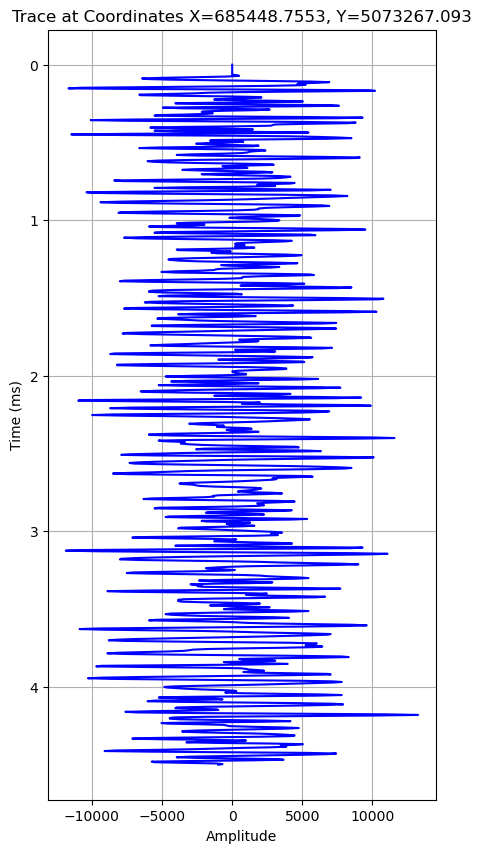

In [1]:
import segyio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Path to SEG-Y file
path = 'C://Users/sushila/Desktop/Data_shared_with Participants/Data/2D Seismic/Virovitica-1/VIR-1-CA9V-95_01._KNGD export.sgy'

# Coordinates to search for
target_x = 685448.7553
target_y = 5073267.093
target_z = 234.6344604

# Read and extract data
with segyio.open(path, "r", strict=False) as f:
    f.mmap()  # Memory map the file for efficient access

    # Extract coordinates from headers
    source_x = np.array(f.attributes(segyio.TraceField.SourceX))
    source_y = np.array(f.attributes(segyio.TraceField.SourceY))

    # Find the trace index that matches the given coordinates (allowing for floating-point precision)
    trace_index = None
    for i, (x, y) in enumerate(zip(source_x, source_y)):
        if np.isclose(x, target_x, atol=1e-3) and np.isclose(y, target_y, atol=1e-3): 
            print(f"Match found at index {i}: x = {x}, y = {y}")
            trace_index = i
            break

    if trace_index is None:
        print("No trace found with the given coordinates.")
        trace_data = None
    else:
        print(f"Trace found at index {trace_index}.")
        # Extract the trace data
        trace_data = f.trace[trace_index]
        
        # Retrieve sampling interval (in ms) and calculate time axis
        dt = segyio.dt(f) / 1000  # Convert to milliseconds
        time_axis = np.arange(len(trace_data)) * dt

# Convert time from milliseconds to seconds
time_axis_seconds = time_axis / 1000  # Now the time is in seconds

# Create a DataFrame with trace amplitude and time
if trace_data is not None:
    df_trace = pd.DataFrame({
        "Time (s)": time_axis_seconds,
        "Amplitude": trace_data
    })

    
    # Plot the selected trace
    plt.figure(figsize=(5, 10))
    plt.plot(df_trace["Amplitude"], df_trace["Time (s)"], color="blue")
    plt.gca().invert_yaxis()  # Invert y-axis to show time increasing downward
    plt.xlabel("Amplitude")
    plt.ylabel("Time (ms)")
    plt.title(f"Trace at Coordinates X={target_x}, Y={target_y}")
    plt.grid()
    plt.show()


In [2]:
from scipy.signal import hilbert
def instantaneous_frequency(seismic_data, sample_rate=4):
    # Compute the analytic signal using Hilbert Transform
    analytic_signal = hilbert(seismic_data)
    
    # Compute the instantaneous phase (angle of analytic signal)
    instantaneous_phase = np.angle(analytic_signal)
    
 
    # compute the derivative and multiply by the sample rate (in Hz)
    phase_derivative = np.diff(instantaneous_phase)  # First derivative of phase
    fs = 1000 / sample_rate  # Convert sample rate to Hz (1/sample_rate in seconds)
    instantaneous_freq = np.abs(phase_derivative) * fs / (2 * np.pi)  # Frequency in Hz
    
    return instantaneous_freq

# Calculate instantaneous frequency
instantaneous_freq = instantaneous_frequency(trace_data, sample_rate=4)
print(len(instantaneous_freq))

# Add NaN to the start to align the length
instantaneous_freq_full = np.concatenate(([np.nan], instantaneous_freq))

df_trace['Instantaneous_freq'] = instantaneous_freq_full
df_trace

1125


,Time (s),Amplitude,Instantaneous_freq
0,0.000,0.000000,NaN
1,0.004,0.000000,0.000171
2,0.008,0.000000,0.000062
3,0.012,0.000000,0.000005
4,0.016,0.000000,0.000095
...,...,...,...
1121,4.484,-5537.105469,224.963486
1122,4.488,-3164.060547,21.752737
1123,4.492,-1087.645508,17.307138
1124,4.496,-692.137695,4.006769


In [3]:
# Initialize the 'ins_freq' column with NaNs first
df_trace['ins_freq'] = np.nan

# Use .loc to set values starting from the second row
df_trace.loc[1:, 'ins_freq'] = instantaneous_freq


# Print the updated DataFrame
df_trace


,Time (s),Amplitude,Instantaneous_freq,ins_freq
0,0.000,0.000000,NaN,NaN
1,0.004,0.000000,0.000171,0.000171
2,0.008,0.000000,0.000062,0.000062
3,0.012,0.000000,0.000005,0.000005
4,0.016,0.000000,0.000095,0.000095
...,...,...,...,...
1121,4.484,-5537.105469,224.963486,224.963486
1122,4.488,-3164.060547,21.752737,21.752737
1123,4.492,-1087.645508,17.307138,17.307138
1124,4.496,-692.137695,4.006769,4.006769


In [4]:
# # Define the desired time interval for resampling
# desired_time_interval = 0.001  # in seconds

# # Ensure the 'Time' column is sorted
# df_trace = df_trace.sort_values(by='Time (s)').reset_index(drop=True)

# # Generate the new time values with the desired interval
# new_time_values = np.arange(df_trace['Time (s)'].min(), df_trace['Time (s)'].max() + desired_time_interval, desired_time_interval)

# # Interpolate amplitude values to match the new time values
# resampled_df_trace = pd.DataFrame({
#     'Time (s)': new_time_values,
#     'Amplitude': np.interp(new_time_values, df_trace['Time (s)'], df_trace['Amplitude']),
#     'Instantaneous_freq': np.interp(new_time_values, df_trace['Time (s)'], df_trace['Instantaneous_freq'])
# })


# resampled_df_trace

In [5]:
# Initialize variables to store the results
first_non_zero_value = None
first_non_zero_index = None

# Iterate over the data
for index, value in enumerate(df_trace['Amplitude']):
    if value != 0:  # Check if the value is non-zero
        first_non_zero_value = value
        first_non_zero_index = index
        break  # Exit the loop once the first non-zero value is found

# Now, the values are stored in the variables
print(f"First non-zero value: {first_non_zero_value} at index {first_non_zero_index}")


First non-zero value: 395.5078125 at index 17


In [6]:
"""There is more information in las files. The provided CSV file do not contain all the
      information from the las files .So lets load las files"""
import os
import glob
import lasio
import pandas as pd

# Define the main folder path containing the subfolders
main_folder_path = r'C://Users/sushila/Desktop/Data_shared_with Participants/Data/Wells/LAS and Reports\Virovitica-1\Las_files'

# Find all LAS files in the Las_files folder
las_files = glob.glob(os.path.join(main_folder_path, "*.las"))

# Create an empty list to store DataFrames
las_dataframes = []

# Track all unique depth values
all_depths = set()

# Loop through each LAS file and read it
for las_file in las_files:
    try:
        # Read the LAS file
        las_data = lasio.read(las_file)
            
        # Convert the LAS file to a DataFrame
        las_df = las_data.df()
            
        # Standardize the depth column name by resetting index and renaming
        las_df.reset_index(inplace=True)  # Bring depth from index to column if needed
        depth_column = next((col for col in las_df.columns if col.lower() == 'depth' or col.lower() == 'dept'), None)

        if depth_column:
            las_df.rename(columns={depth_column: 'Depth'}, inplace=True)
        else:
            raise ValueError("Depth column not found in LAS file")

        # Update the set of all depth values
        all_depths.update(las_df['Depth'].unique())

        # Append this DataFrame to the list
        las_dataframes.append(las_df)

    except Exception as e:
        print(f"Error reading {las_file}: {e}")

# If there are LAS DataFrames, merge them
if las_dataframes:
    # Create a complete depth DataFrame
    all_depths_df = pd.DataFrame(sorted(all_depths), columns=['Depth'])

    # Align each DataFrame to the complete depth range and merge
    for i, las_df in enumerate(las_dataframes):
        las_dataframes[i] = pd.merge(all_depths_df, las_df, on='Depth', how='left')

    # Concatenate all aligned DataFrames
    lass_df = pd.concat(las_dataframes, axis=1)

    # Combine duplicate columns and calculate averages for existing values
    def combine_columns(df):
        combined_df = pd.DataFrame()
        for col in df.columns:
            # Identify columns with the same name
            matching_cols = [c for c in df.columns if c == col]
            if len(matching_cols) > 1:  # If there are duplicate columns with the same name
                # Calculate the mean of the columns, prioritizing non-NaN values
                combined_df[col] = df[matching_cols].mean(axis=1, skipna=True)
            else:
                # If there's no duplicate, just keep the original column
                combined_df[col] = df[col]

        return combined_df


    lass_df = combine_columns(lass_df)

    # Drop duplicate depth rows and sort
    lass_df = lass_df.drop_duplicates(subset=['Depth']).sort_values(by='Depth')

    # Set Depth as the index
    lass_df.set_index('Depth', inplace=True)

    # Reset index, which will bring Depth back as a column
    lass_df.reset_index(inplace=True)

else:
    lass_df = pd.DataFrame()  # Empty DataFrame if no LAS files were found

# Display the final DataFrame with Depth as both column and index
lass_df


,Depth,CAL,CAL1,CAL2,R16,R64,RLML,RNML,SPT,RT,SP,TEMP
0,50.0,12.867,12.867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50.1,12.867,12.867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50.2,12.867,12.867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50.3,12.867,12.867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50.4,12.867,12.867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
28446,2894.6,NaN,NaN,NaN,45.65550,75.35200,NaN,NaN,65.0553,NaN,73.37,NaN
28447,2894.7,NaN,NaN,NaN,45.65385,74.93035,NaN,NaN,65.0553,NaN,73.37,NaN
28448,2894.8,NaN,NaN,NaN,45.66235,74.45335,NaN,NaN,65.0553,NaN,73.37,NaN
28449,2894.9,NaN,NaN,NaN,45.66850,73.99235,NaN,NaN,65.0553,NaN,73.37,NaN


In [7]:
lass_df.columns


Index(['Depth', 'CAL', 'CAL1', 'CAL2', 'R16', 'R64', 'RLML', 'RNML', 'SPT',
       'RT', 'SP', 'TEMP'],
      dtype='object')

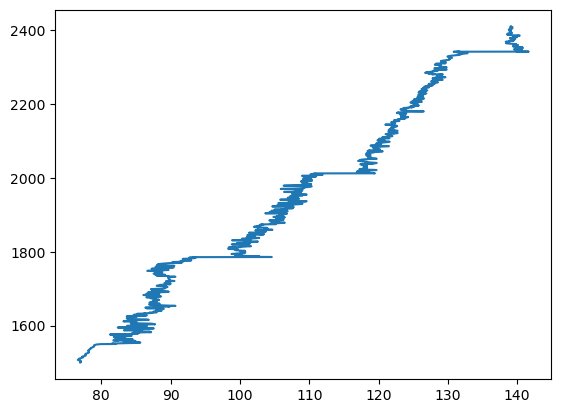

In [8]:
plt.plot(lass_df['TEMP'],lass_df['Depth'])

In [9]:
# AC value is missing. Lets take it from neighbouring well 'VIROVITICA_3ALFA'
ac_df = lasio.read('C://Users\sushila\Desktop\Data_shared_with Participants\Data\Wells\LAS and Reports\Virovitica_3 Alfa\Las_files/Vir-3_raw_wds.las')
ac_dff = ac_df.df()
ac_dff1 = ac_dff.rename_axis('Depth').reset_index()
ac_dff2 = ac_dff1.reset_index(drop=True)
ac_dff2 = ac_dff2[['Depth', 'AC']]
ac_dff2 

,Depth,AC
0,100.0000,NaN
1,100.1000,NaN
2,100.2000,NaN
3,100.3000,NaN
4,100.4000,NaN
...,...,...
38266,3926.6001,0.0001
38267,3926.7001,0.0001
38268,3926.8001,0.0001
38269,3926.9001,NaN


In [10]:
las_df = pd.merge(lass_df,ac_dff2 , on="Depth", how="inner")
las_df

,Depth,CAL,CAL1,CAL2,R16,R64,RLML,RNML,SPT,RT,SP,TEMP,AC
0,100.0,11.567,11.5663,NaN,15.93035,28.63600,NaN,NaN,58.5203,NaN,50.145,NaN,NaN
1,100.5,11.534,11.5343,NaN,16.31085,28.63600,NaN,NaN,58.4299,NaN,50.099,NaN,NaN
2,101.0,11.501,11.5007,NaN,17.81415,28.63600,NaN,NaN,54.7303,NaN,46.306,NaN,NaN
3,101.5,11.467,11.4673,NaN,18.31815,28.63600,NaN,NaN,54.1106,NaN,45.682,NaN,NaN
4,102.0,11.432,11.4323,NaN,16.91435,28.63600,NaN,NaN,55.4363,NaN,47.033,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978,2893.0,NaN,NaN,NaN,50.73285,89.87385,NaN,NaN,65.0553,NaN,73.370,NaN,59.5890
5979,2893.5,NaN,NaN,NaN,47.15200,83.37665,NaN,NaN,65.0553,NaN,73.370,NaN,57.4218
5980,2894.0,NaN,NaN,NaN,45.78150,77.78900,NaN,NaN,65.0553,NaN,73.370,NaN,56.1317
5981,2894.5,NaN,NaN,NaN,45.67265,75.76565,NaN,NaN,65.0553,NaN,73.370,NaN,58.0088


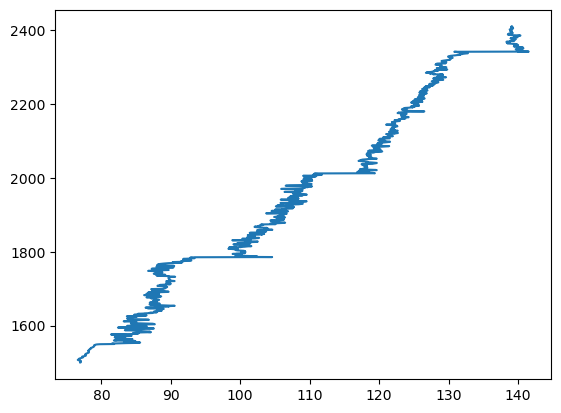

In [11]:
plt.plot(las_df['TEMP'],las_df['Depth'])

In [12]:
# plt.plot(df_VIROVITICA_1['TEMP'],df_VIROVITICA_1['Depth'])
# plt.plot(las_df['TEMP'],las_df['Depth'])

In [13]:
sonic_df = las_df[['Depth','AC']]
sonic_df = sonic_df.dropna()
sonic_velocity = 1 / sonic_df['AC'] * 10**6 * 0.3048

sonic_df['Sonic_velocity'] = sonic_velocity 

sonic_df


,Depth,AC,Sonic_velocity
4970,2490.0,60.6393,5026.443247
4971,2490.5,61.5772,4949.884048
4972,2491.0,64.4591,4728.579828
4973,2491.5,66.0860,4612.172018
4974,2492.0,66.9124,4555.209498
...,...,...,...
5978,2893.0,59.5890,5115.038010
5979,2893.5,57.4218,5308.088566
5980,2894.0,56.1317,5430.086742
5981,2894.5,58.0088,5254.375198


In [14]:
depth_1, vel_1 = sonic_df['Depth'].values[0], sonic_df['Sonic_velocity'].values[0]  # (x1, y1)
depth_2, vel_2 = sonic_df['Depth'].values[-1], sonic_df['Sonic_velocity'].values[-1]  # (x2, y2)

# Generate depths from 0 to 386 with 0.1 m increments
depths = np.arange(0, sonic_df['Depth'].values[0]+0.1, 0.1)  # Ensure the last value is included

# Apply the interpolation formula for each depth
velocities = vel_1 + (vel_2 - vel_1) * (depths - depth_1) / (depth_2 - depth_1)

# Combine depths and velocities into a DataFrame for easier visualization
interpolated_df = pd.DataFrame({'Depth': depths, 'Sonic_Velocity': velocities})
# Concatenate the DataFrames
comb_df = pd.concat([interpolated_df, sonic_df], axis=0).sort_values(by='Depth').reset_index(drop=True)
# Combine the 'Sonic_Velocity' columns
# Replace NaN in the first column with values from the second column
if 'Sonic_Velocity' in comb_df.columns and 'Sonic_velocity' in comb_df.columns:
    comb_df['Sonic_Velocity'] = comb_df['Sonic_Velocity'].fillna(comb_df['Sonic_velocity'])
    # Drop the redundant column
    comb_df.drop(columns=['Sonic_velocity'], inplace=True)
# Depths from first non-zero value to the last depth in 0.1m increments

comb_df

,Depth,Sonic_Velocity,AC
0,0.0,4008.792716,NaN
1,0.1,4008.833585,NaN
2,0.2,4008.874455,NaN
3,0.3,4008.915324,NaN
4,0.4,4008.956194,NaN
...,...,...,...
25909,2893.0,5115.038010,59.5890
25910,2893.5,5308.088566,57.4218
25911,2894.0,5430.086742,56.1317
25912,2894.5,5254.375198,58.0088


In [15]:
combined_df = pd.merge(comb_df, las_df, on="Depth", how="left")
combined_df

,Depth,Sonic_Velocity,AC_x,CAL,CAL1,CAL2,R16,R64,RLML,RNML,SPT,RT,SP,TEMP,AC_y
0,0.0,4008.792716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1,4008.833585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.2,4008.874455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.3,4008.915324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.4,4008.956194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25909,2893.0,5115.038010,59.5890,NaN,NaN,NaN,50.73285,89.87385,NaN,NaN,65.0553,NaN,73.37,NaN,59.5890
25910,2893.5,5308.088566,57.4218,NaN,NaN,NaN,47.15200,83.37665,NaN,NaN,65.0553,NaN,73.37,NaN,57.4218
25911,2894.0,5430.086742,56.1317,NaN,NaN,NaN,45.78150,77.78900,NaN,NaN,65.0553,NaN,73.37,NaN,56.1317
25912,2894.5,5254.375198,58.0088,NaN,NaN,NaN,45.67265,75.76565,NaN,NaN,65.0553,NaN,73.37,NaN,58.0088


In [19]:
depths = combined_df['Depth']
depths = depths[first_non_zero_index:]

# Velocities starting from the first non-zero depth
velocities = combined_df['Sonic_Velocity'].values 
velocities = velocities [first_non_zero_index:]

# Calculate time for each 0.1m segment
delta_depth = 0.1  # Interval in meters
time_intervals = 2 * (delta_depth / velocities)  # Two-way travel time for each segment

# Calculate cumulative two-way travel time
cumulative_time = np.cumsum(time_intervals)  # Cumulative sum of time intervals

# Create a DataFrame to store the results
travel_time_df = pd.DataFrame({
    'Depth': depths,
    'Sonic_Velocity': velocities,
    'Two_Way_Travel_Time': cumulative_time
})

# Merge TEMP values from sonic_df with the travel_time_df based on Depth
final_df = pd.merge(travel_time_df, las_df[['Depth', 'TEMP', 'R64']], on='Depth', how='left')


final_df.dropna(inplace = True)
final_df = final_df.reset_index(drop = True)
final_df

,Depth,Sonic_Velocity,Two_Way_Travel_Time,TEMP,R64
0,1500.0,4621.835205,0.695570,76.961,29.82250
1,1500.5,4622.039552,0.695786,77.034,29.81785
2,1501.0,4622.243900,0.696003,77.034,29.73815
3,1501.5,4622.448247,0.696219,76.964,26.18150
4,1502.0,4622.652595,0.696435,76.945,23.84335
...,...,...,...,...,...
1816,2408.0,4992.930258,1.073508,139.235,19.48935
1817,2408.5,4993.134605,1.073709,139.216,18.56050
1818,2409.0,4993.338953,1.073909,139.006,18.83165
1819,2409.5,4993.543300,1.074109,139.132,19.82215


In [20]:
# Assign values from 'Two_Way_Travel_Time' to 'Time (s)'
final_df['Time (s)'] = final_df['Two_Way_Travel_Time']

# Drop the 'Two_Way_Travel_Time' column
final_df.drop(columns=['Two_Way_Travel_Time'], inplace=True)


# Step 1: Filter the time columns to avoid values beyond the range (if needed)
final_df_filtered = final_df[final_df['Time (s)'] <= max(final_df['Time (s)'])]
resampled_df_trace_filtered = df_trace[df_trace['Time (s)'] <= max(final_df['Time (s)'])]

# Step 2: Create a dictionary to map each `Two_Way_Travel_Time` to the nearest `Time (s)` from df_trace
# This will find the nearest time value for each entry in final_df['Two_Way_Travel_Time']
final_df_filtered['Nearest_Time (s)'] = final_df_filtered['Time (s)'].apply(
    lambda x: resampled_df_trace_filtered['Time (s)'].iloc[(np.abs(resampled_df_trace_filtered['Time (s)'] - x)).argmin()]
)

# Step 3: Ensure that the `Two_Way_Travel_Time` values are unique after mapping the nearest values
# Remove duplicates in 'Nearest_Time (s)' while keeping the first occurrence
final_df_filtered = final_df_filtered.drop_duplicates(subset=['Nearest_Time (s)'], keep='first')

# Step 4: Replace `Two_Way_Travel_Time` with `Nearest_Time (s)`
final_df_filtered['Time (s)'] = final_df_filtered['Nearest_Time (s)']

# Step 5: Drop the 'Nearest_Time (s)' column as it's no longer needed
final_df_filtered.drop(columns=['Nearest_Time (s)'], inplace=True)

# Display the updated DataFrame
final_df_filtered


,Depth,Sonic_Velocity,TEMP,R64,Time (s)
0,1500.0,4621.835205,76.961,29.82250,0.696
12,1506.0,4624.287375,76.733,8.91285,0.700
30,1515.0,4627.965630,77.280,11.68200,0.704
49,1524.5,4631.848232,77.882,23.55485,0.708
67,1533.5,4635.526487,78.227,27.26765,0.712
...,...,...,...,...,...
1719,2359.5,4973.108551,140.018,23.49415,1.056
1739,2369.5,4977.195501,138.898,29.98700,1.060
1759,2379.5,4981.282451,139.503,22.18300,1.064
1779,2389.5,4985.369400,138.594,20.05735,1.068


In [23]:
# Perform an inner join on the 'Time (s)' column to keep only common time values
merged_df = pd.merge(final_df_filtered, df_trace, on="Time (s)", how="inner")
# Feature Engineering
merged_df ['Amplitude_abs'] = merged_df ['Amplitude'].abs()  # Absolute value
merged_df ['Amplitude_roll_mean'] = merged_df ['Amplitude'].rolling(window=5, min_periods=1).mean()  # Rolling mean
merged_df ['Amplitude_energy'] = merged_df ['Amplitude'] ** 2  # Energy
merged_df

,Depth,Sonic_Velocity,TEMP,R64,Time (s),Amplitude,Instantaneous_freq,ins_freq,Amplitude_abs,Amplitude_roll_mean,Amplitude_energy
0,1500.0,4621.835205,76.961,29.82250,0.696,1483.154297,36.818657,36.818657,1483.154297,1483.154297,2.199747e+06
1,1506.0,4624.287375,76.733,8.91285,0.700,-889.891602,49.123230,49.123230,889.891602,296.631348,7.919071e+05
2,1515.0,4627.965630,77.280,11.68200,0.704,-2175.291016,198.771973,198.771973,2175.291016,-527.342773,4.731891e+06
3,1524.5,4631.848232,77.882,23.55485,0.708,-1087.645508,38.968800,38.968800,1087.645508,-667.418457,1.182973e+06
4,1533.5,4635.526487,78.227,27.26765,0.712,1384.277344,30.304729,30.304729,1384.277344,-257.079297,1.916224e+06
...,...,...,...,...,...,...,...,...,...,...,...
90,2359.5,4973.108551,140.018,23.49415,1.056,8305.656250,22.688892,22.688892,8305.656250,98.876367,6.898393e+07
91,2369.5,4977.195501,138.898,29.98700,1.060,9492.179688,22.788830,22.788830,9492.179688,3183.834961,9.010147e+07
92,2379.5,4981.282451,139.503,22.18300,1.064,7316.890625,23.023138,23.023138,7316.890625,5635.981836,5.353689e+07
93,2389.5,4985.369400,138.594,20.05735,1.068,3065.184570,23.076351,23.076351,3065.184570,6466.547852,9.395356e+06


In [24]:
#Get the last depth value from las_df
last_depth = las_df['Depth'].values[-1]

# Assuming merged_df['Depth'] contains depth values sorted in ascending order
nearest_depth_idx = (merged_df['Depth'] - last_depth).abs().argmin()
nearest_depth = merged_df['Depth'].iloc[nearest_depth_idx]

# All rows starting from the nearest depth onward
cropped_merged_df = merged_df[merged_df['Depth'] <= nearest_depth]

# Step 4: Save the cropped dataframe to a CSV
cropped_merged_df.to_csv('VIROVITICA_1_ALL.csv', index=False)

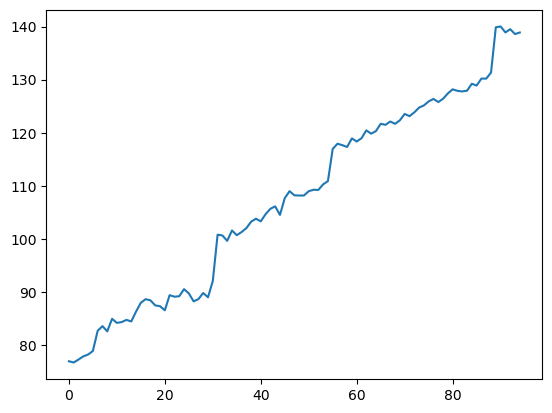

In [25]:
plt.plot(merged_df['TEMP'])

In [26]:
# Select the columns you need
merged_df_temp = merged_df[['Time (s)', 'Depth','TEMP', 'Amplitude', 'Instantaneous_freq', 'Amplitude_abs', 'Amplitude_roll_mean', 'Amplitude_energy']]

# Make a copy to avoid the SettingWithCopyWarning
merged_df_temp = merged_df_temp.copy()

# Drop rows with NaN values
merged_df_temp.dropna(inplace=True)

# Reset the index after dropping NaN values
merged_df_temp.reset_index(drop=True, inplace=True)

# Save the DataFrame to a CSV file
merged_df_temp.to_csv('C://Users\sushila\Desktop\Hackathon/VIROVITICA_1_TEMP.csv', index=False)

# Optionally, print a confirmation message
print("CSV file saved successfully!")

# Display the final DataFrame
merged_df_temp


CSV file saved successfully!


,Time (s),Depth,TEMP,Amplitude,Instantaneous_freq,Amplitude_abs,Amplitude_roll_mean,Amplitude_energy
0,0.696,1500.0,76.961,1483.154297,36.818657,1483.154297,1483.154297,2.199747e+06
1,0.700,1506.0,76.733,-889.891602,49.123230,889.891602,296.631348,7.919071e+05
2,0.704,1515.0,77.280,-2175.291016,198.771973,2175.291016,-527.342773,4.731891e+06
3,0.708,1524.5,77.882,-1087.645508,38.968800,1087.645508,-667.418457,1.182973e+06
4,0.712,1533.5,78.227,1384.277344,30.304729,1384.277344,-257.079297,1.916224e+06
...,...,...,...,...,...,...,...,...
90,1.056,2359.5,140.018,8305.656250,22.688892,8305.656250,98.876367,6.898393e+07
91,1.060,2369.5,138.898,9492.179688,22.788830,9492.179688,3183.834961,9.010147e+07
92,1.064,2379.5,139.503,7316.890625,23.023138,7316.890625,5635.981836,5.353689e+07
93,1.068,2389.5,138.594,3065.184570,23.076351,3065.184570,6466.547852,9.395356e+06


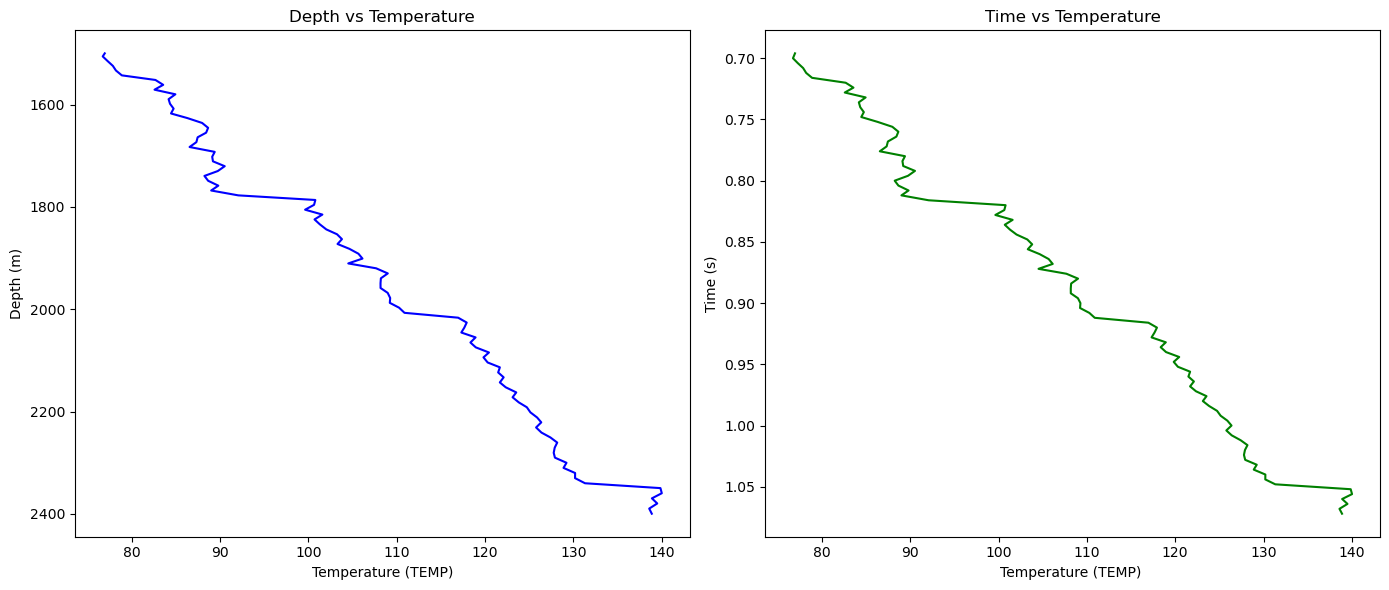

In [27]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Depth vs Temperature on the first subplot
axes[0].plot(merged_df_temp['TEMP'], merged_df_temp['Depth'], color='blue')
axes[0].set_xlabel('Temperature (TEMP)')
axes[0].set_ylabel('Depth (m)')
axes[0].invert_yaxis()  # Invert the y-axis to have depth increase downwards
axes[0].set_title('Depth vs Temperature')

# Plot Time vs Temperature on the second subplot
axes[1].plot(merged_df_temp['TEMP'], merged_df_temp['Time (s)'] , color='green')
axes[1].set_xlabel('Temperature (TEMP) ')
axes[1].set_ylabel('Time (s)')
axes[1].invert_yaxis() 
axes[1].set_title('Time vs Temperature')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [28]:
merged_df['RD'] = merged_df['R64']
# Select the columns you need
merged_df_RT = merged_df[['Time (s)', 'Depth','RD', 'Amplitude', 'Instantaneous_freq', 'Amplitude_abs', 'Amplitude_roll_mean', 'Amplitude_energy']]

# Make a copy to avoid the SettingWithCopyWarning
merged_df_RT = merged_df_RT.copy()

# Drop rows with NaN values
merged_df_RT.dropna(inplace=True)

# Reset the index after dropping NaN values
merged_df_RT.reset_index(drop=True, inplace=True)

# Save the DataFrame to a CSV file
merged_df_RT.to_csv('C://Users\sushila\Desktop\Hackathon/VIROVITICA_1_RT.csv', index=False)

# Optionally, print a confirmation message
print("CSV file saved successfully!")




CSV file saved successfully!


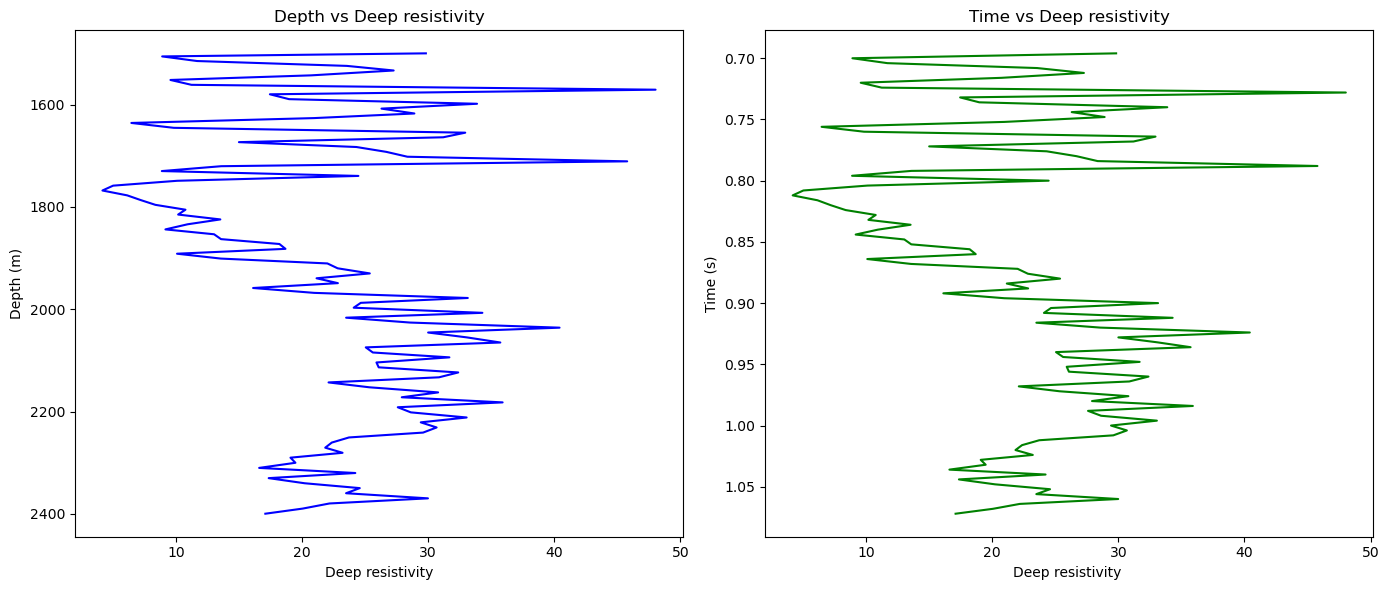

In [29]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#  first subplot
axes[0].plot(merged_df_RT['RD'], merged_df_RT['Depth'], color='blue')
axes[0].set_xlabel('Deep resistivity')
axes[0].set_ylabel('Depth (m)')
axes[0].invert_yaxis()  # Invert the y-axis to have depth increase downwards
axes[0].set_title('Depth vs Deep resistivity')

#  second subplot
axes[1].plot(merged_df_RT['RD'], merged_df_RT['Time (s)'] , color='green')
axes[1].set_xlabel('Deep resistivity ')
axes[1].set_ylabel('Time (s)')
axes[1].invert_yaxis() 
axes[1].set_title('Time vs Deep resistivity')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()
